# Forecasting with scikit-learn Regressors using Reduction in sktime

This tutorial demonstrates how traditional machine learning models from **scikit-learn** can be used for time series forecasting through **reduction techniques** in **sktime**.

Reduction transforms a forecasting problem into a supervised regression task, allowing us to leverage powerful tabular models for temporal prediction.

---

## Learning Objectives

By the end of this tutorial you will:

- Understand reduction-based forecasting
- Learn the difference between **recursive** and **direct** strategies
- Convert time series into tabular features using **WindowSummarizer**
- Build forecasting pipelines
- Understand why preprocessing such as **differencing** is critical for trend extrapolation


In [4]:
import warnings

import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import make_reduction
from sktime.split import temporal_train_test_split
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.utils.plotting import plot_series

warnings.filterwarnings("ignore")

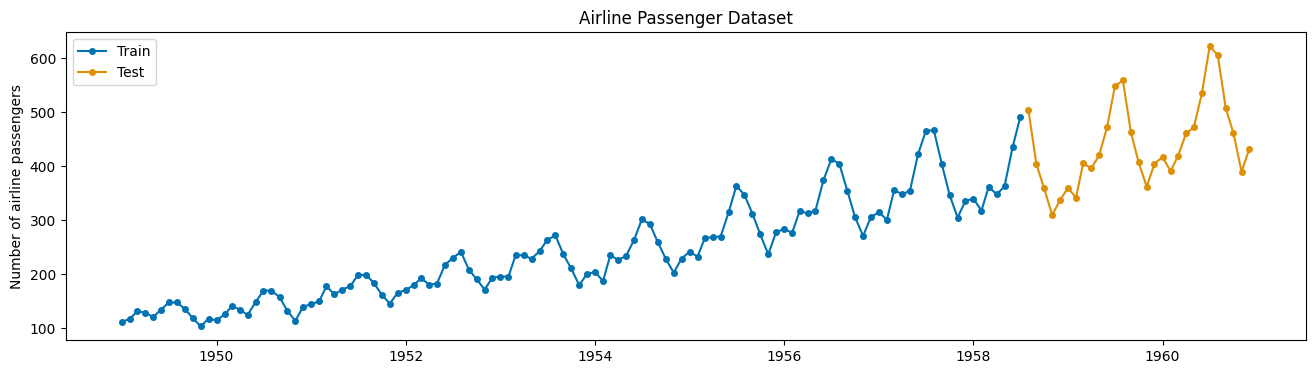

In [22]:
y = load_airline()

y_train, y_test = temporal_train_test_split(y, test_size=0.2)
fh = ForecastingHorizon(y_test.index, is_relative=False)

plot_series(y_train, y_test, labels=["Train", "Test"])
plt.title("Airline Passenger Dataset")
plt.show()

## 1. What is Reduction?

Reduction is a strategy that converts a time series forecasting problem into a supervised machine learning task.

Instead of modeling temporal dependencies directly, past observations are transformed into tabular features that can be used by standard regressors.

This enables us to use the rich ecosystem of **scikit-learn** models for forecasting.

![Reduction diagram](img/reduction.png)


## 2. Creating Tabular Features with WindowSummarizer

`WindowSummarizer` automatically extracts lagged values and summary statistics from the time series.

These tabular features allow regression models to learn temporal structure.


In [23]:
window = WindowSummarizer(lag_feature={"lag": [1, 2, 3, 12], "mean": [[1, 3]]})

## 3. Recursive Reduction Strategy and why preprocessing matters

The recursive strategy trains **one model** and generates forecasts step-by-step.

Predictions are fed back into the model to forecast further ahead.


In [38]:
forecaster_recursive = make_reduction(
    RandomForestRegressor(random_state=42),
    window_length=None,  # VERY IMPORTANT
    strategy="recursive",
    transformers=[window],
    pooling="global",
)

forecaster_recursive.fit(y_train)

RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(random_state=42),
                                     pooling='global',
                                     transformers=[WindowSummarizer(lag_feature={'lag': [1,
                                                                                         2,
                                                                                         3,
                                                                                         12],
                                                                                 'mean': [[1,
                                                                                           3]]})],
                                     window_length=None)

We will notice that the model struggles to extrapolate the upward trend in the data. This is because the features are based on past values, and without preprocessing, the model cannot learn to predict beyond the range of the training data. 

This is one of the most common errors when using reduction-based forecasting: forgetting to preprocess the data to make it more amenable to extrapolation. 

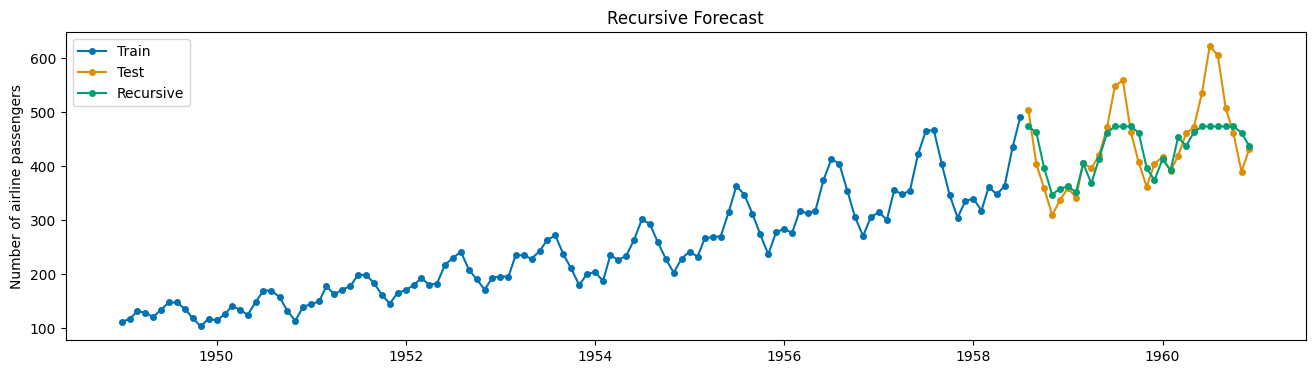

In [39]:
y_pred_recursive = forecaster_recursive.predict(fh=fh)

plot_series(y_train, y_test, y_pred_recursive, labels=["Train", "Test", "Recursive"])
plt.title("Recursive Forecast")
plt.show()

We can use `Differencer` to remove the trend and make the data stationary, which allows the model to learn patterns that can be extrapolated. After forecasting, sktime automatically inverts the differencing transformation to return predictions on the original scale.

In [40]:

forecaster_recursive_diff = Differencer() * forecaster_recursive

forecaster_recursive_diff.fit(y_train)

TransformedTargetForecaster(steps=[Differencer(),
                                   RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(random_state=42),
                                                                        pooling='global',
                                                                        transformers=[WindowSummarizer(lag_feature={'lag': [1,
                                                                                                                            2,
                                                                                                                            3,
                                                                                                                            12],
                                                                                                                    'mean': [[1,
                                                                                                                              3]]})],
                                                                        window_length=None)])

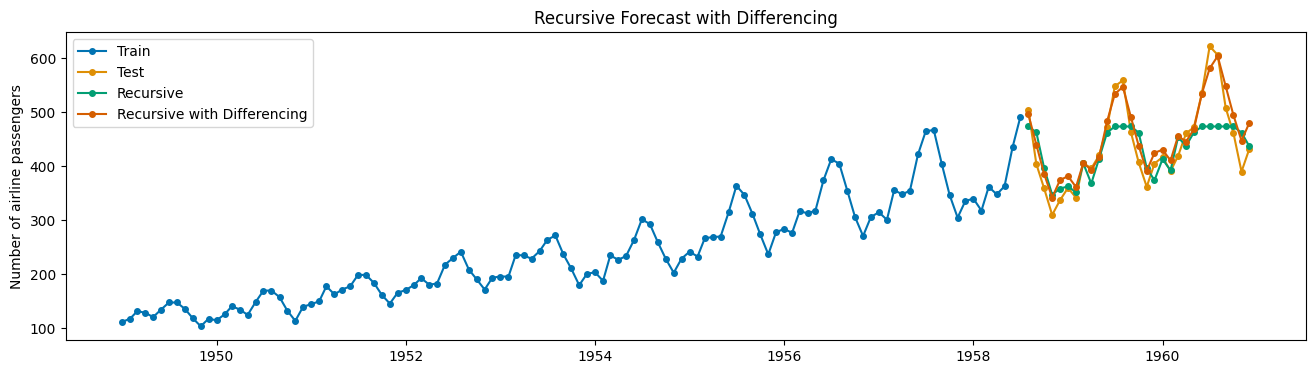

In [41]:
y_pred_recursive_diff = forecaster_recursive_diff.predict(fh=fh)

plot_series(
    y_train,
    y_test,
    y_pred_recursive,
    y_pred_recursive_diff,
    labels=["Train", "Test", "Recursive", "Recursive with Differencing"],
)
plt.title("Recursive Forecast with Differencing")
plt.show()

Much better. Suggestion: try experimenting with different preprocessing techniques, such as detrending, to see how they affect the model's ability to forecast trends.

## 4. Direct Reduction Strategy

The direct strategy trains **separate models for each forecasting horizon**.

It is often more stable for long-range forecasts since it avoids error propagation. Without preprocessing, we will see that the direct strategy also struggles to capture the trend, as each model is trained on the original scale of the data.


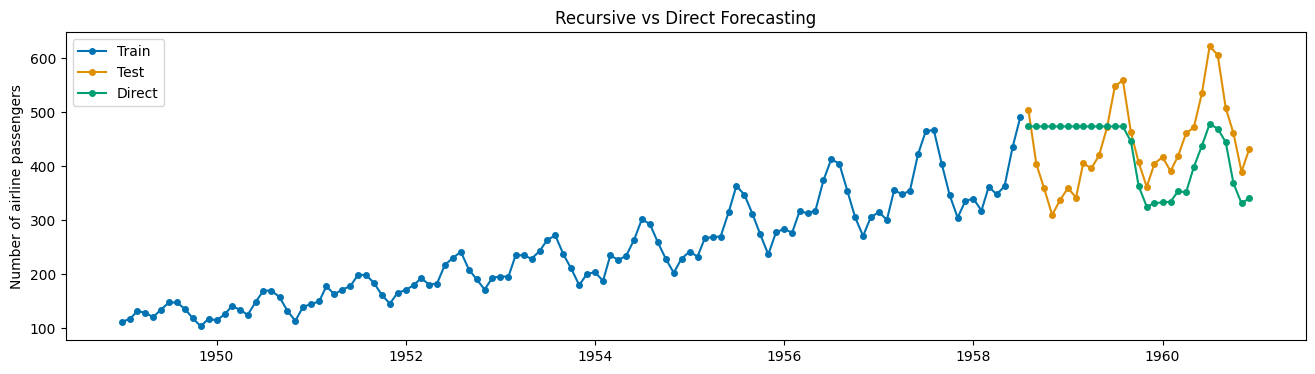

In [42]:
forecaster_direct = make_reduction(
    RandomForestRegressor(random_state=42),
    window_length=None,
    strategy="direct",
    transformers=[window],
    pooling="global",
)

relative_fh = list(range(1, len(y_test) + 1))

forecaster_direct.fit(y_train, fh=relative_fh)
y_pred_direct = forecaster_direct.predict(fh=relative_fh)

plot_series(y_train, y_test, y_pred_direct, labels=["Train", "Test", "Direct"])
plt.title("Recursive vs Direct Forecasting")
plt.show()

We also train one direct model with differencing, and we see that it captures the trend much better.

In [43]:
forecaster_direct_diff = Differencer() * forecaster_direct

forecaster_direct_diff.fit(y_train, fh=relative_fh)

TransformedTargetForecaster(steps=[Differencer(),
                                   DirectTabularRegressionForecaster(estimator=RandomForestRegressor(random_state=42),
                                                                     pooling='global',
                                                                     transformers=[WindowSummarizer(lag_feature={'lag': [1,
                                                                                                                         2,
                                                                                                                         3,
                                                                                                                         12],
                                                                                                                 'mean': [[1,
                                                                                                                           3]]})],
                                                                     window_length=None)])

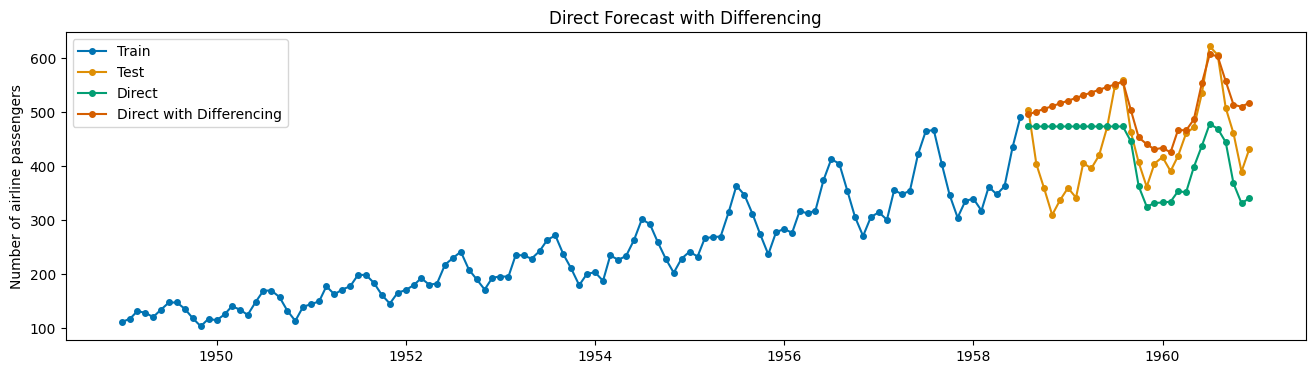

In [44]:
y_pred_direct_diff = forecaster_direct_diff.predict(fh=relative_fh)

plot_series(
    y_train,
    y_test,
    y_pred_direct,
    y_pred_direct_diff,
    labels=["Train", "Test", "Direct", "Direct with Differencing"],
)
plt.title("Direct Forecast with Differencing")
plt.show()

## Key Takeaways

- Reduction enables scikit-learn regressors to solve forecasting tasks.
- WindowSummarizer provides an efficient way to create tabular features from time series.
- Preprocessing steps such as differencing are often essential for capturing trends.
- sktime pipelines allow seamless integration of transformations and forecasting models.
